### An exploration of clustering methods to derive insights from a heart rate dataset

In [1]:
import random
import numpy as np

seed = 42
np.random.seed(seed)
random.seed(seed)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.impute import KNNImputer
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.spatial.distance import cdist

##### Data loading

In [2]:
df = pd.read_csv("data/HR_data.csv")
df.head()

print(df.shape)

(312, 68)


##### Data preprocessing

In [3]:
# Define metadata and emotion columns
meta_cols = ['Unnamed: 0', 'Round', 'Phase', 'Individual', 'Puzzler', 'Cohort']
emotion_cols = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']


# Handle missing values
imputer = KNNImputer(n_neighbors=5)
df.loc[:, 'HR_TD_Mean':'EDA_TD_P_ReT'] = imputer.fit_transform(df.loc[:, 'HR_TD_Mean':'EDA_TD_P_ReT'])

# Standardize
X = df.drop(columns=meta_cols + emotion_cols)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled.columns=X.columns

Data exploration

In [4]:
print(X_scaled.describe().T.head(10))

                 count          mean       std       min       25%       50%  \
HR_TD_Mean       312.0  6.148928e-16  1.001606 -1.842929 -0.658962 -0.155370   
HR_TD_Median     312.0  1.651101e-16  1.001606 -1.931596 -0.619626 -0.153454   
HR_TD_std        312.0  9.821204e-17  1.001606 -1.144348 -0.678307 -0.325759   
HR_TD_Min        312.0  5.124106e-17  1.001606 -2.120748 -0.706174 -0.130104   
HR_TD_Max        312.0 -6.547469e-17  1.001606 -1.424107 -0.690513 -0.260621   
HR_TD_AUC        312.0 -6.148928e-16  1.001606 -2.346675 -0.684697 -0.163108   
HR_TD_Kurtosis   312.0 -2.277381e-17  1.001606 -0.953056 -0.557278 -0.241126   
HR_TD_Skew       312.0  5.266443e-17  1.001606 -3.168766 -0.640688 -0.017973   
HR_TD_Slope_min  312.0  1.850372e-17  1.001606 -7.163244 -0.248985  0.282766   
HR_TD_Slope_max  312.0  1.024821e-16  1.001606 -0.944999 -0.481532 -0.225827   

                      75%        max  
HR_TD_Mean       0.441405   6.458080  
HR_TD_Median     0.468419   7.494958  
HR

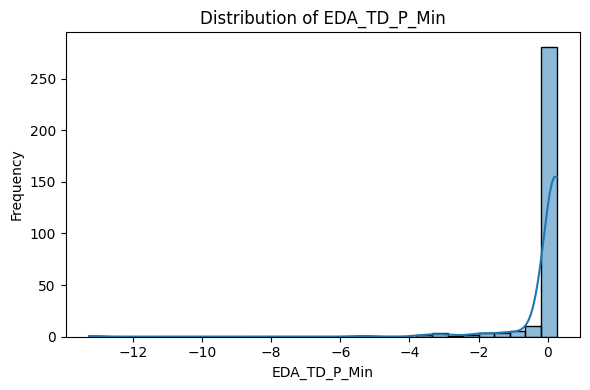

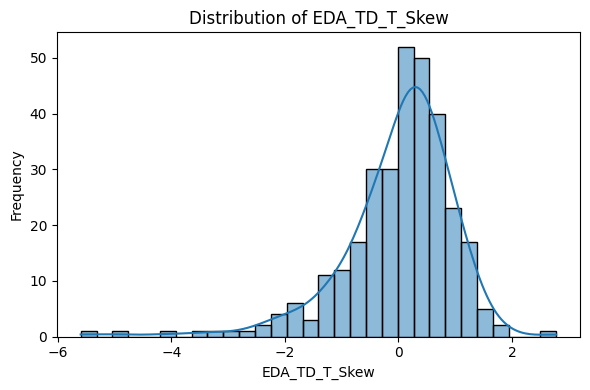

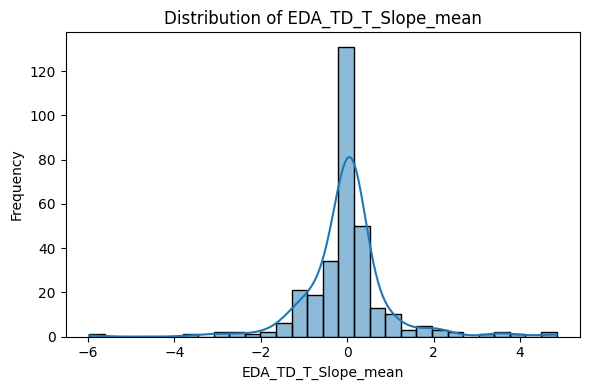

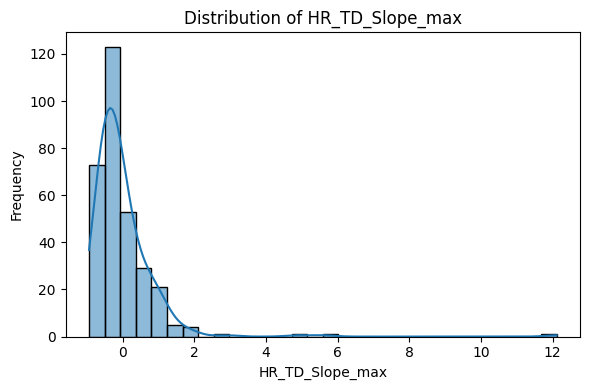

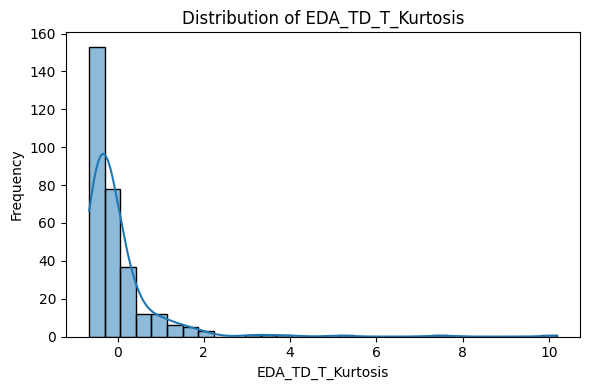

In [5]:
#outliers
selected_cols=["EDA_TD_P_Min", 
    "EDA_TD_T_Skew", 
    "EDA_TD_T_Slope_mean", 
    "HR_TD_Slope_max",
    "EDA_TD_T_Kurtosis"]

import matplotlib.pyplot as plt
import seaborn as sns 

for col in selected_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(X_scaled[col],bins=30,kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [6]:
# Winsorization
winsor_cols=['EDA_TD_P_Min', 'HR_TD_Slope_max', 'EDA_TD_T_Kurtosis']

X_scaled_df = X_scaled.copy()

for col in winsor_cols:
    X_scaled_df[col]=X_scaled_df[col].clip(lower=-4,upper=4)

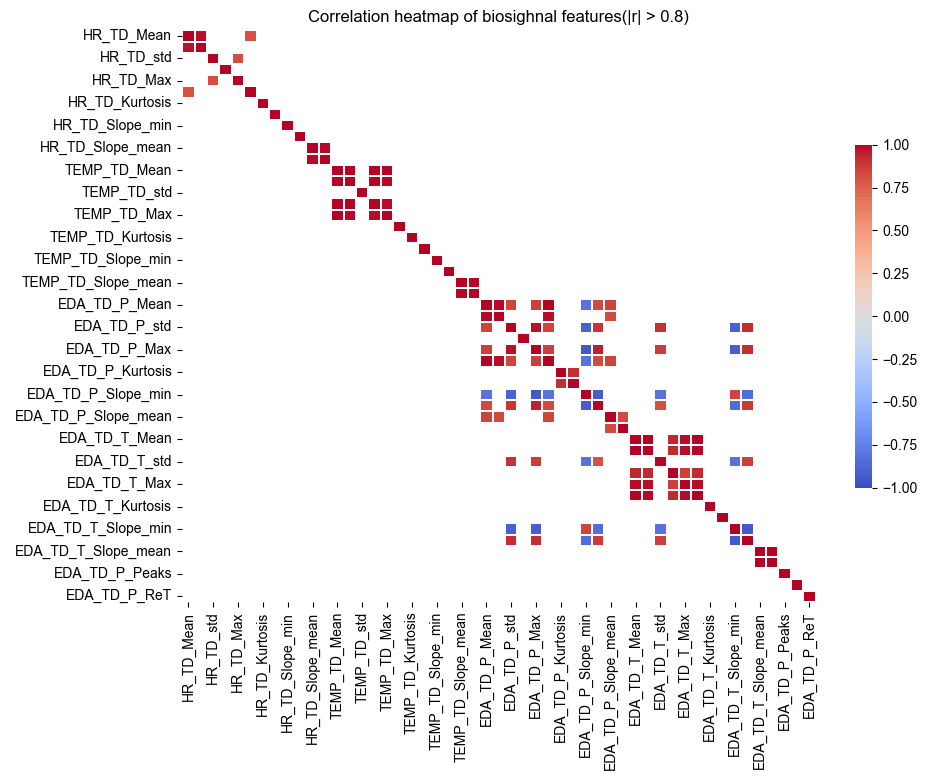

In [7]:
#Correlation heatmap
corr=X_scaled.corr()

mask = corr.abs() < 0.8
corr_vis = corr.mask(mask)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_vis,
    cmap="coolwarm",
    center=0,
    vmin=-1, vmax=1,
    linewidths=.3,
    cbar_kws={"shrink":0.6},
    )
sns.set_theme(style="whitegrid") 
plt.title("Correlation heatmap of biosighnal features(|r| > 0.8)")
plt.tight_layout()
plt.show()

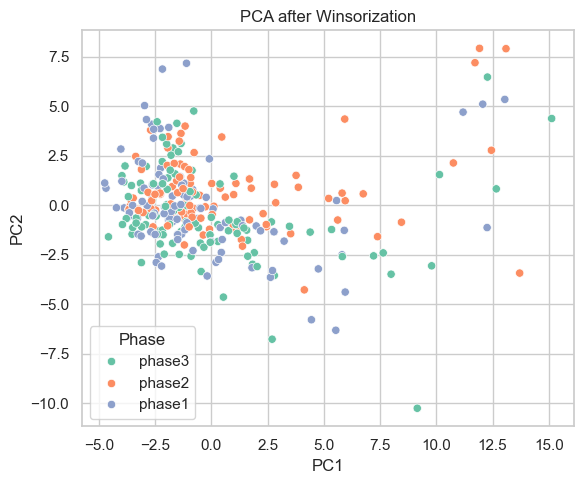

PC1 explained variance: 27.81%
PC2 explained variance: 10.05%
PC1+PC2 cumulative explained variance: 37.86%


In [8]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2,random_state=42) 
X_pca=pca.fit_transform(X_scaled) 


vis=pd.DataFrame(X_pca,columns=["PC1","PC2"]) 
vis["Phase"]=df["Phase"].values

plt.figure(figsize=(6,5))
sns.scatterplot(data=vis,x="PC1",y="PC2",hue="Phase",palette="Set2")
plt.title('PCA after Winsorization')
plt.tight_layout()
plt.show()

var_ratios=pca.explained_variance_ratio_
pc1_pct=var_ratios[0]*100
pc2_pct=var_ratios[1]*100
cum_pct=(var_ratios[0]+var_ratios[1])*100
print(f"PC1 explained variance: {pc1_pct:.2f}%")
print(f"PC2 explained variance: {pc2_pct:.2f}%")
print(f"PC1+PC2 cumulative explained variance: {cum_pct:.2f}%")

The first two principal components account for 37.86 % of the total variance, indicating that much of the structure still lies in higher-order components.

##### K-means clustering


Gap-statistic, optimal K = 5

Sihouette heuristic, optimal K = 2


/var/folders/f6/xq96xscs7x9fp_tdy_vm0p2c0000gn/T/ipykernel_24322/1605514361.py:46: RuntimeWarning: divide by zero encountered in log
  ElogWu = np.mean(np.log(Wu), axis = 1)
/var/folders/f6/xq96xscs7x9fp_tdy_vm0p2c0000gn/T/ipykernel_24322/1605514361.py:47: RuntimeWarning: divide by zero encountered in log
  sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim)
/opt/homebrew/Caskroom/miniconda/base/envs/CompDataAnalysis/lib/python3.12/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


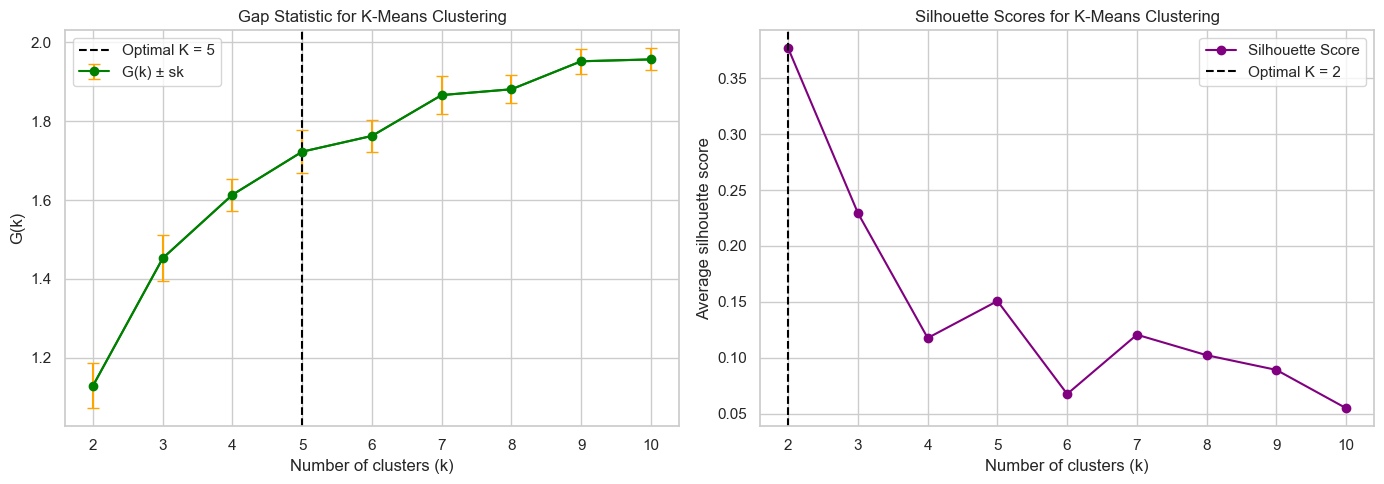

In [9]:
X_scaled = pd.DataFrame(scaler.fit_transform(X))
X_scaled = X_scaled.astype(float).values

clustersNr = 10
Nsim = 20
list_of_clusters = range(1, clustersNr + 1)
N, p = X_scaled.shape
minX = np.min(X_scaled, axis=0)
maxX = np.max(X_scaled, axis=0)

W = np.zeros(clustersNr)
Wu = np.zeros((clustersNr, Nsim))
silhouette_scores = []

for k in list_of_clusters:
    kmeans = KMeans(n_clusters=k).fit(X_scaled)
    C = kmeans.cluster_centers_
    labels = kmeans.labels_
    
    for cluster in range(1, k+1):
        Ik = np.where(labels == cluster - 1)[0]
        dk = np.sum((X_scaled[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[k-1] += Dk

    for j in range(Nsim):
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        kmeansU = KMeans(n_clusters=k).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelsU = kmeansU.labels_
        
        for cluster in range(k):
            Iku = np.where(labelsU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[k - 1, j] += Dku

    if k >= 2:
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores.append(silhouette_avg)
    else:
        silhouette_scores.append(np.nan)

# Compute Gap statistic
logW = np.log(W)
ElogWu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim)
x_range = np.array(list_of_clusters)
Gk = ElogWu.T - np.log(W)

# Determine optimal number of clusters
K_gap_candidates = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]
K_gap = x_range[-1] if not K_gap_candidates.size else x_range[K_gap_candidates[0]]
print(f"\nGap-statistic, optimal K = {K_gap}")
K_silhouette = x_range[np.nanargmax(silhouette_scores)]
print(f"\nSihouette heuristic, optimal K = {K_silhouette}")

# Plot Gap curve and Silhouette curve
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].errorbar(x_range, Gk, yerr=sk, fmt='-o', color='green', ecolor='orange', elinewidth=1.5, capsize=4, label='G(k) ± sk')
axs[0].plot(x_range, Gk, color='green') 
axs[0].axvline(K_gap, linestyle='--', color='black', label=f"Optimal K = {K_gap}")
axs[0].set_title("Gap Statistic for K-Means Clustering")
axs[0].set_xlabel("Number of clusters (k)")
axs[0].set_ylabel("G(k)")
axs[0].legend()
axs[0].grid(True)

axs[1].plot(x_range, silhouette_scores, color='purple', marker='o', label='Silhouette Score')
axs[1].axvline(K_silhouette, linestyle='--', color='black', label=f"Optimal K = {K_silhouette}")
axs[1].set_title("Silhouette Scores for K-Means Clustering")
axs[1].set_xlabel("Number of clusters (k)")
axs[1].set_ylabel("Average silhouette score")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

/var/folders/f6/xq96xscs7x9fp_tdy_vm0p2c0000gn/T/ipykernel_24322/1061069968.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap("viridis")


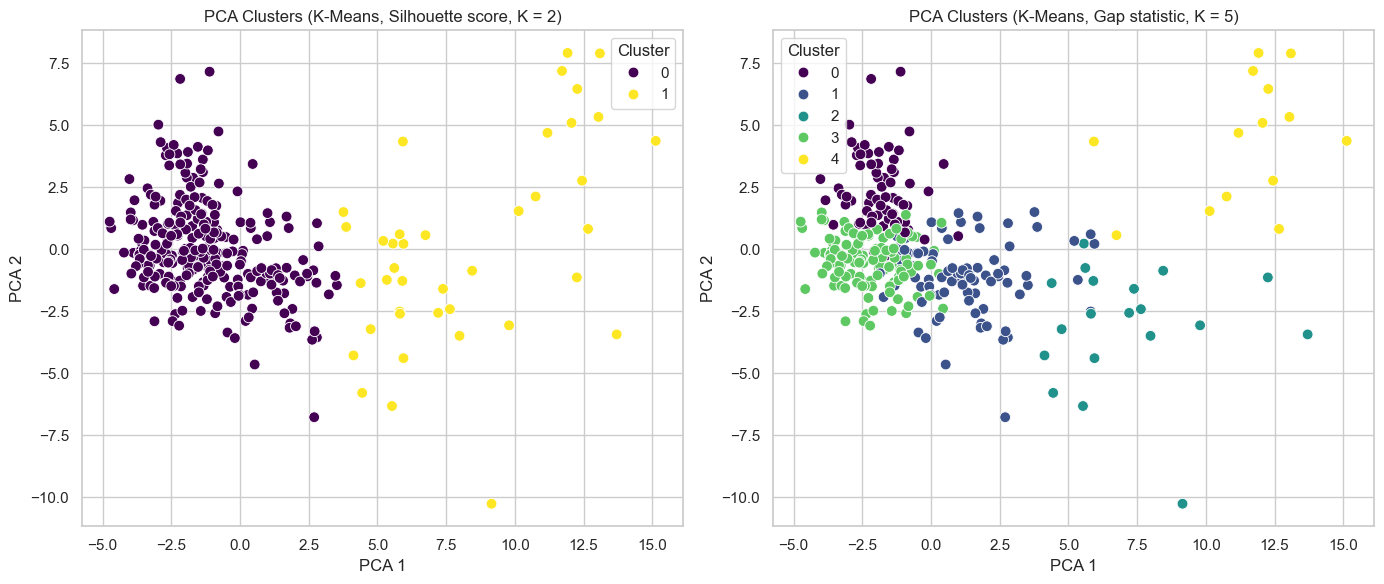

In [10]:
# Fit K Means models
kmeans_sil = KMeans(n_clusters=K_silhouette).fit(X_scaled)
kmeans_gap = KMeans(n_clusters=K_gap).fit(X_scaled)
labels_sil = kmeans_sil.labels_
labels_gap = kmeans_gap.labels_

# PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

viridis = get_cmap("viridis")

def get_color_palette(n):
    norm = Normalize(vmin=0, vmax=n-1)
    return [viridis(norm(i)) for i in range(n)]

# Plot PCA projection with clusters
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_sil,
                palette=get_color_palette(K_silhouette), s=60, ax=axs[0])
axs[0].set_title(f"PCA Clusters (K-Means, Silhouette score, K = {K_silhouette})")
axs[0].set_xlabel("PCA 1")
axs[0].set_ylabel("PCA 2")
axs[0].legend(title="Cluster")

# Gap-based clustering
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gap,
                palette=get_color_palette(K_gap), s=60, ax=axs[1])
axs[1].set_title(f"PCA Clusters (K-Means, Gap statistic, K = {K_gap})")
axs[1].set_xlabel("PCA 1")
axs[1].set_ylabel("PCA 2")
axs[1].legend(title="Cluster")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

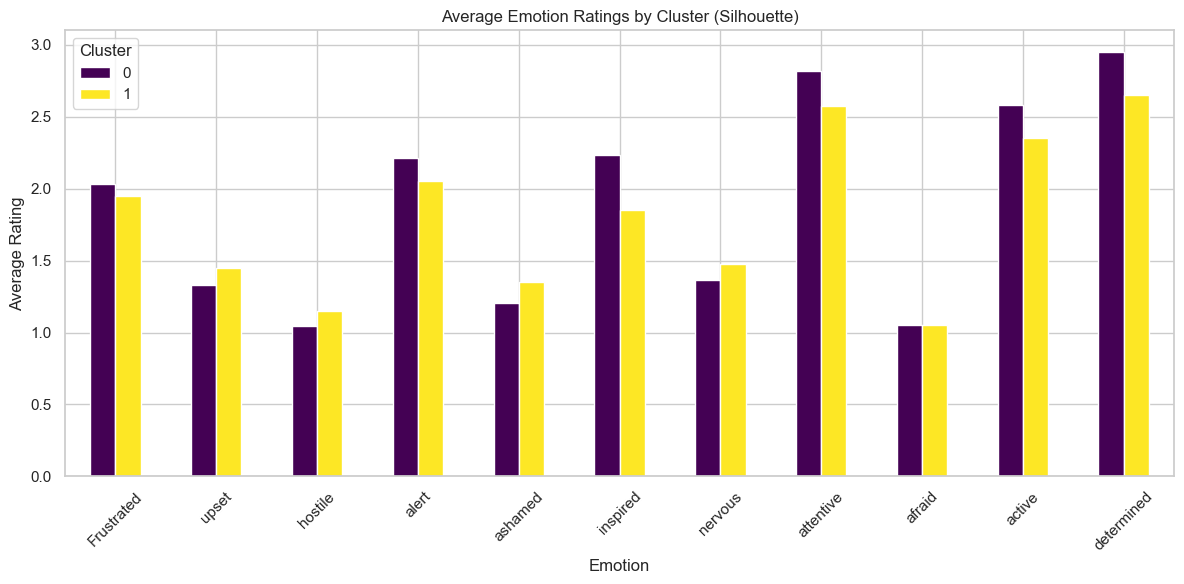

<Figure size 1200x600 with 0 Axes>

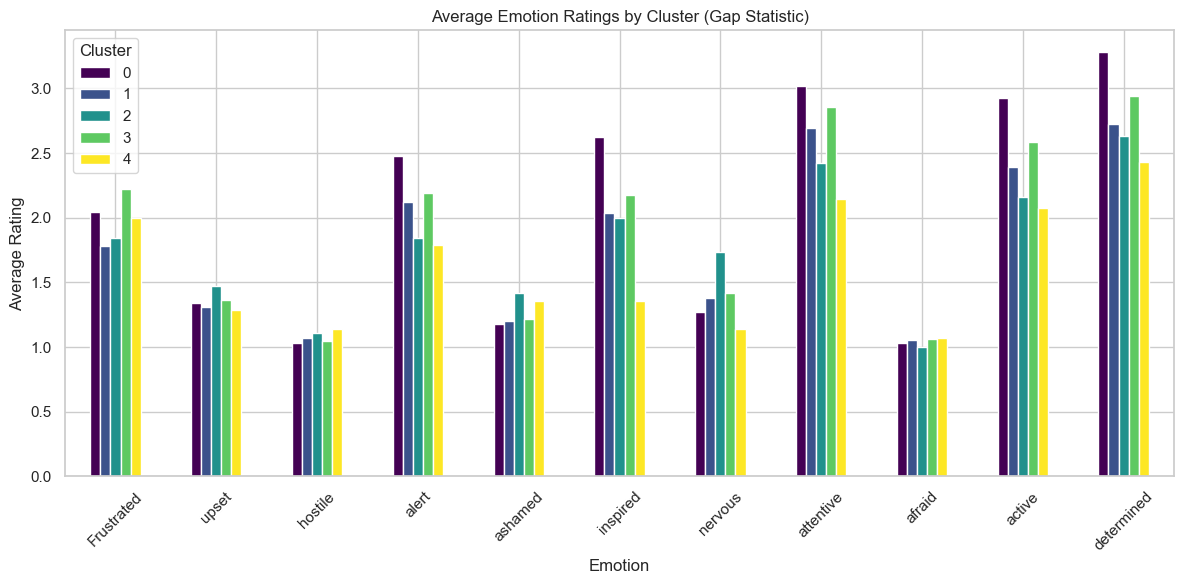

In [11]:
emotion_data_sil = df[emotion_cols].copy()
emotion_data_sil['Cluster'] = labels_sil
emotion_means_sil = emotion_data_sil.groupby('Cluster').mean().T

plt.figure(figsize=(12, 6))
emotion_means_sil.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Average Emotion Ratings by Cluster (Silhouette)")
plt.ylabel("Average Rating")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# Bar plot using gap statistic clusters
emotion_data_gap = df[emotion_cols].copy()
emotion_data_gap['Cluster'] = labels_gap
emotion_means_gap = emotion_data_gap.groupby('Cluster').mean().T

plt.figure(figsize=(12, 6))
emotion_means_gap.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Average Emotion Ratings by Cluster (Gap Statistic)")
plt.ylabel("Average Rating")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Agglomerative clustering

Optimal number of clusters (Agglomerative): 2


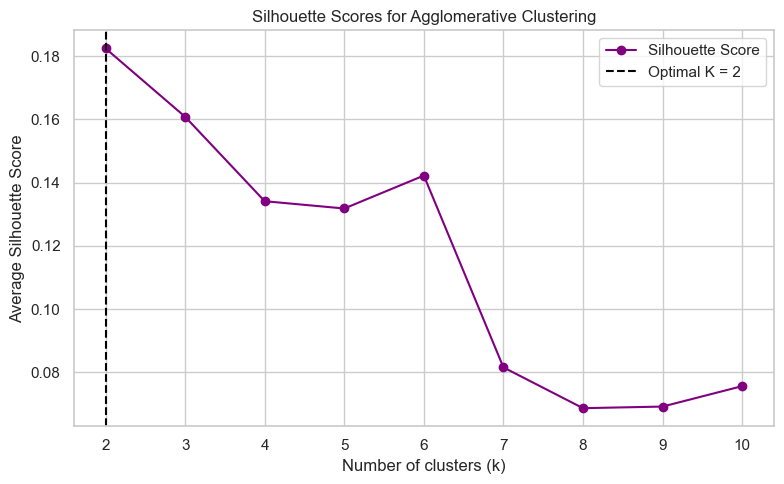

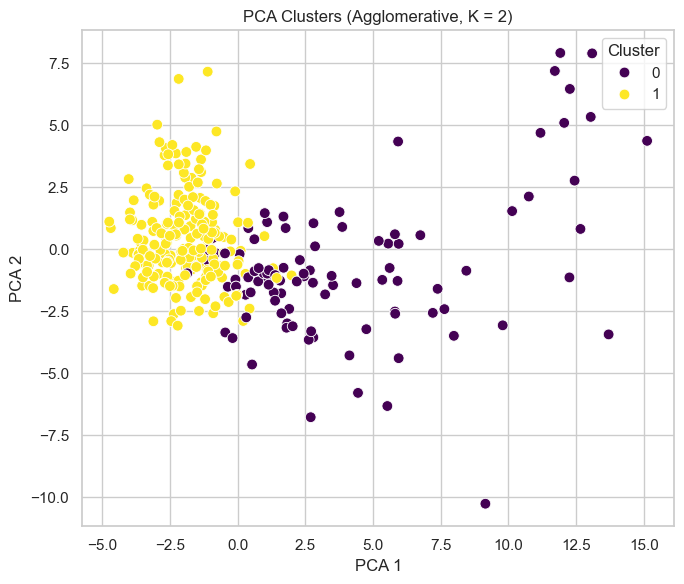

In [12]:
silhouette_scores_agglo = []
cluster_range = range(2, 11)

for k in cluster_range:
    agglo = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = agglo.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores_agglo.append(score)

# Choose best K
optimal_k_agglo = cluster_range[np.argmax(silhouette_scores_agglo)]
print(f"Optimal number of clusters (Agglomerative): {optimal_k_agglo}")

# Plot Silhouette scores
plt.figure(figsize=(8,5))
plt.plot(cluster_range, silhouette_scores_agglo, color='purple', marker='o', label='Silhouette Score')
plt.axvline(optimal_k_agglo, linestyle='--', color='black', label=f"Optimal K = {K_silhouette}")
plt.title("Silhouette Scores for Agglomerative Clustering")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

agglo_best = AgglomerativeClustering(n_clusters=optimal_k_agglo, linkage='ward')
agglo_labels = agglo_best.fit_predict(X_scaled)

# Plot PCA projection with agglomerative clusters
plt.figure(figsize=(7,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=agglo_labels,
                palette=get_color_palette(optimal_k_agglo), s=60)
plt.title(f"PCA Clusters (Agglomerative, K = {optimal_k_agglo})")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

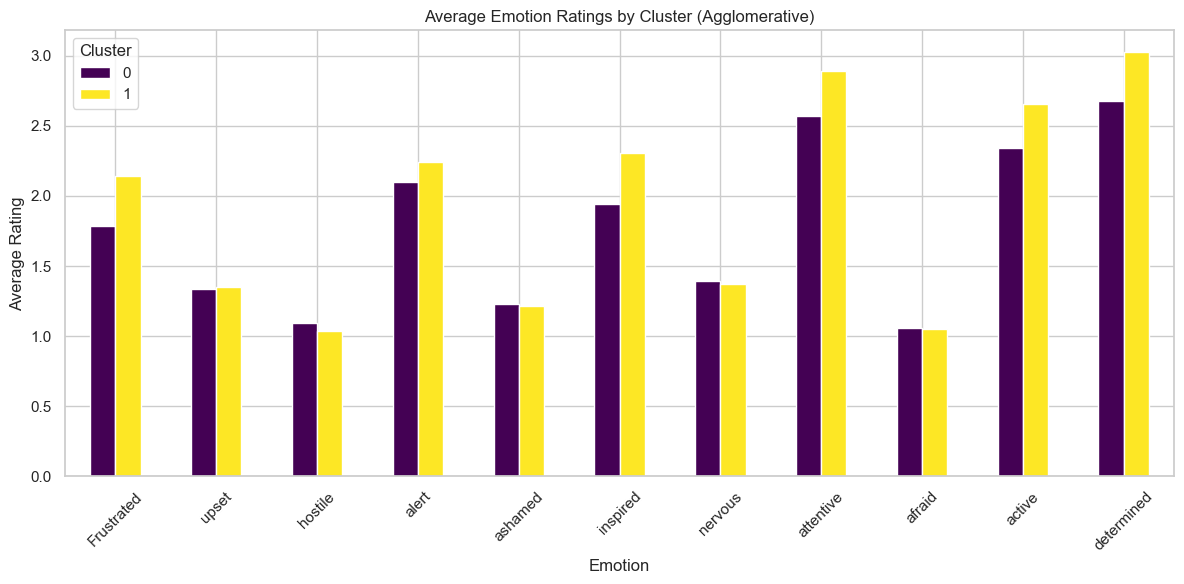

In [13]:
emotion_data_agglo = df[emotion_cols].copy()
emotion_data_agglo['Cluster'] = agglo_labels
emotion_means_agglo = emotion_data_agglo.groupby('Cluster').mean().T

plt.figure(figsize=(12, 6))
emotion_means_agglo.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Average Emotion Ratings by Cluster (Agglomerative)")
plt.ylabel("Average Rating")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


##### Gaussian Mixture

Best number of clusters according to AIC: 3
Best number of clusters according to BIC: 1


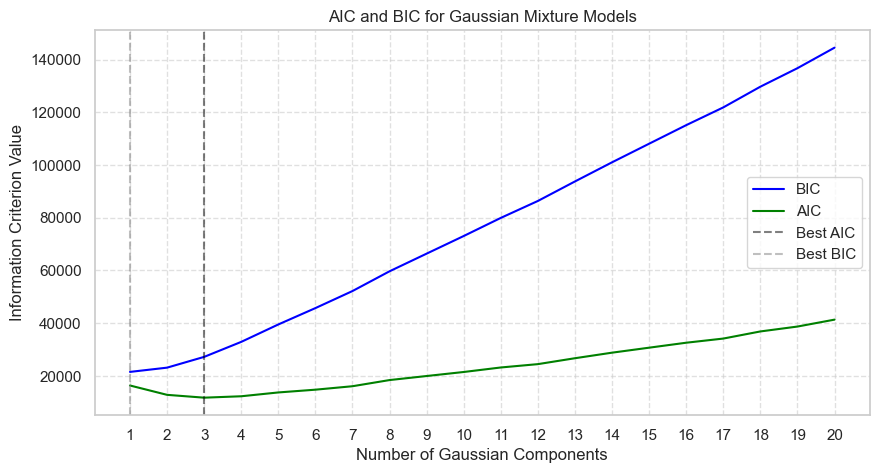

In [14]:
k = 20

BIC = []
AIC = []

# Investigate AIC and BIC
for k in range(1, k+1):
    gmm = GaussianMixture(n_components = k, covariance_type  = "full", max_iter = 1000, reg_covar = 0.01, random_state=seed)
    gmm.fit(X_scaled)
    BIC.append(gmm.bic(X_scaled))
    AIC.append(gmm.aic(X_scaled))

bic_scores = np.array(BIC)
aic_scores = np.array(AIC)
    
# Find best models
best_aic_k = np.argmin(aic_scores) + 1
best_bic_k = np.argmin(bic_scores) + 1

print(f"Best number of clusters according to AIC: {best_aic_k}")
print(f"Best number of clusters according to BIC: {best_bic_k}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, k + 1), bic_scores, label="BIC", color='blue')
plt.plot(range(1, k + 1), aic_scores, label="AIC", color='green')
plt.axvline(best_aic_k, linestyle='--', color='black', alpha=0.5, label="Best AIC")
plt.axvline(best_bic_k, linestyle='--', color='gray', alpha=0.5, label="Best BIC")
plt.xticks(np.arange(1, k + 1, 1))
plt.xlabel("Number of Gaussian Components")
plt.title("AIC and BIC for Gaussian Mixture Models")
plt.ylabel("Information Criterion Value")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

/var/folders/f6/xq96xscs7x9fp_tdy_vm0p2c0000gn/T/ipykernel_24322/1858982304.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = get_cmap("viridis")


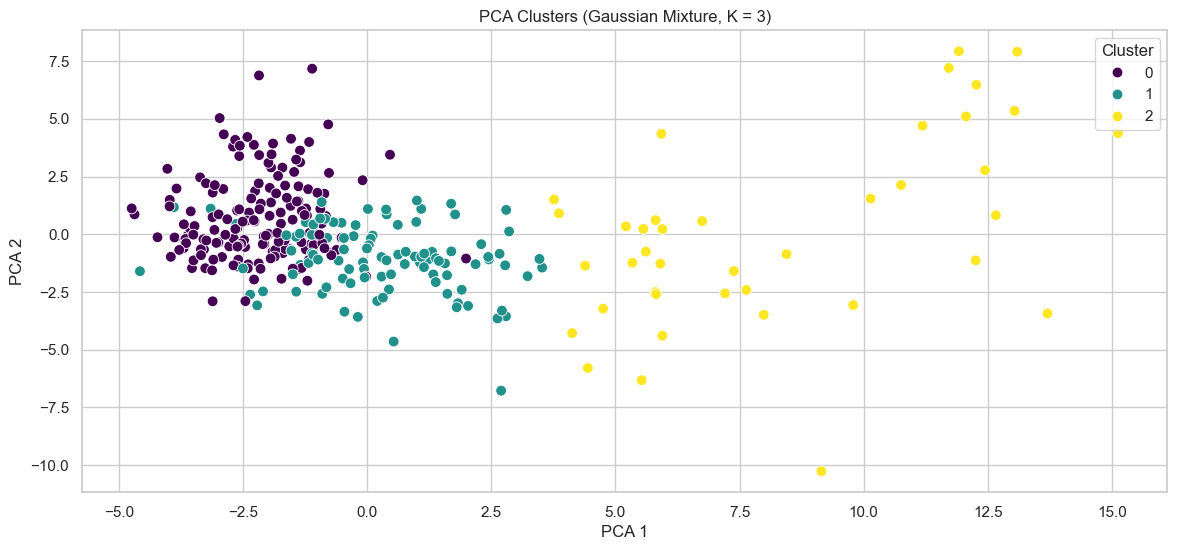

In [15]:
# Fit GMM with best number of clusters
best_gmm = GaussianMixture(n_components=best_aic_k, covariance_type="full", max_iter=1000, reg_covar=0.01, random_state=42)
best_gmm.fit(X_scaled)
labels_gmm = best_gmm.predict(X_scaled)

# PCA projection
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

viridis = get_cmap("viridis")

def get_color_palette(n):
    norm = Normalize(vmin=0, vmax=n-1)
    return [viridis(norm(i)) for i in range(n)]

# Plot PCA projection with clusters
fig, axs = plt.subplots(figsize=(14, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels_gmm,
                palette=get_color_palette(best_aic_k), s=60, ax=axs)
axs.set_title(f"PCA Clusters (Gaussian Mixture, K = {best_aic_k})")
axs.set_xlabel("PCA 1")
axs.set_ylabel("PCA 2")
axs.legend(title="Cluster")

<Figure size 1200x600 with 0 Axes>

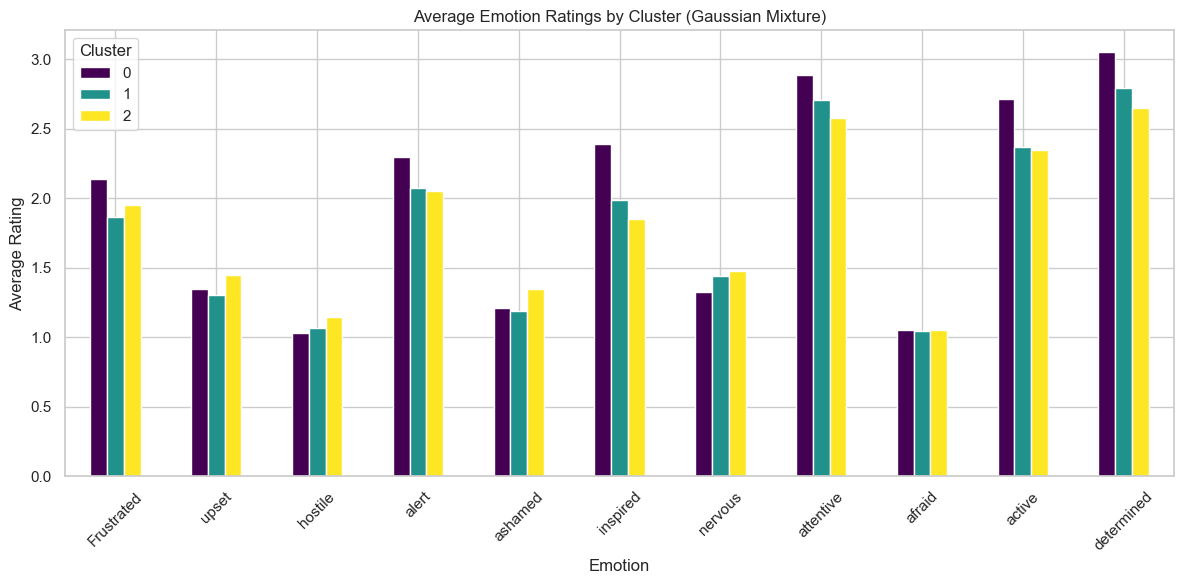

In [16]:
emotion_data_gmm = df[emotion_cols].copy()
emotion_data_gmm['Cluster'] = labels_gmm
emotion_means_gmm = emotion_data_gmm.groupby('Cluster').mean().T

plt.figure(figsize=(12, 6))
emotion_means_gmm.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Average Emotion Ratings by Cluster (Gaussian Mixture)")
plt.ylabel("Average Rating")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

##### Results